## DIFFERENT OPTIMIZERS


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import torch.backends.cudnn as cudnn
import sys
import time
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
valid_ratio = 0.9

In [ ]:
# creating Training and Testing Data Loaders and Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
train_data = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=128, shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

n_train_examples = int(len(train_data) * valid_ratio)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = transform_test

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=128, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=128, shuffle=False, num_workers=2)

valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=128, shuffle=False)

# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = test_data.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [ ]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

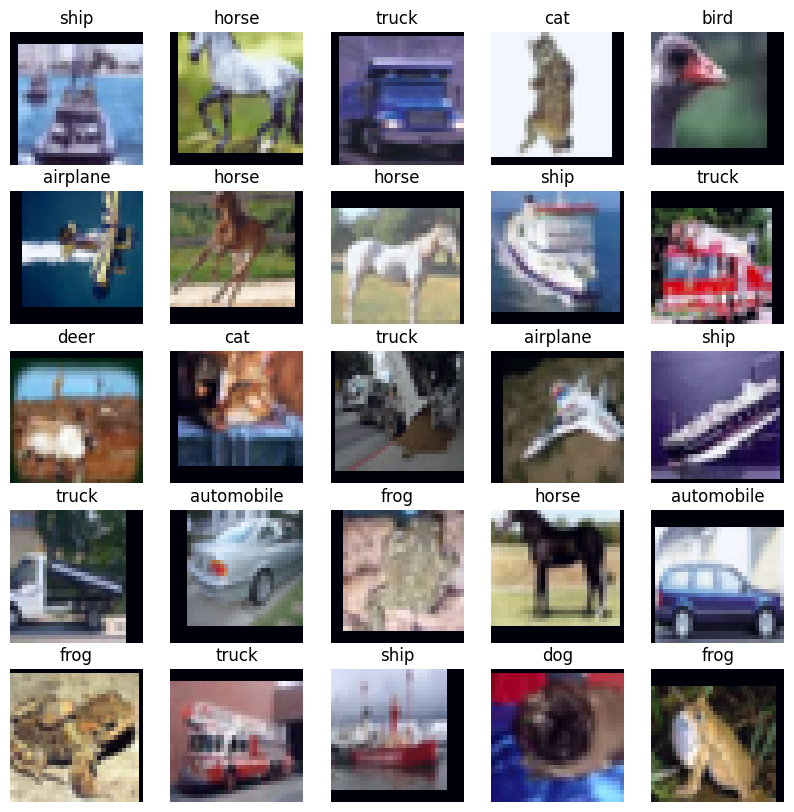

In [ ]:
plot_images(images, labels, classes, normalize = True)

BASE MODEL (OPTIMIZER = SGD, LR = 0.005)



In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)         # Convolutional Layer 1
        self.bn1 = nn.BatchNorm2d(planes)                                                   # Batch Normalization  
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)                             #Convolutional Layer 2
        self.bn2 = nn.BatchNorm2d(planes)                                                   # Batch Normalisation    

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(                                                  # Creating a shortcut connection
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    #Forward Pass of Basic Block
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)      # first hidden layer
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)     # second hidden layer
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)     # third hidden layer
        # self.layer4 = self.x(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)               #fully connected linear output layer

    #Utility function to create sequential layers of BasicBlock
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    # Forward Pass 
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 7)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
def ResNet18():
    return ResNet(BasicBlock, [3,2,3])    #numbers represent number of residual blocks for each of three layers

In [ ]:
#Instatiate model and move it to gpu
model = ResNet18()
model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

In [ ]:
from torchsummary import summary
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [ ]:
#number of traininable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters in the model: ", num_params)

Total number of parameters in the model:  4032330


In [ ]:
#Chossing SGD as the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
# Calculating accuracy
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
#Traing function
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)   # Moving images and their labels to the gpu
        optimizer.zero_grad()                                     # Setting gradient to 0 
        y_pred = model(inputs)                                    # calculating outputs
        loss = criterion(y_pred, targets)                         # Calculating loss
        acc = calculate_accuracy(y_pred, targets)                 # Calculating accuracy 
        loss.backward()                                           # back propogation step
        optimizer.step()                                          # Updating weights using computed gradient
        train_loss += loss.item()
        correct += acc.item()
    return train_loss / len(train_loader), correct / len(train_loader)


In [ ]:
#Testing Function
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)   # Moving images and their labels to the gpu
            outputs = model(inputs)                                   # calculating outputs
            loss = criterion(outputs, targets)                        # Calculating loss
            acc = calculate_accuracy(outputs, targets)                # Calculating accuracy
            test_loss += loss.item()
            correct += acc.item()
    return test_loss / len(test_loader), correct / len(test_loader)

    # Save checkpoint.
    acc_temp = 100.*correct/total
    if acc_temp > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc_temp,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc_temp


In [ ]:
#Validation funtion
def validate(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)   # Moving images and their labels to the gpu
            outputs = model(inputs)                                   # calculating outputs
            loss = criterion(outputs, targets)                        # Calculating loss
            acc = calculate_accuracy(outputs, targets)                # Calculating accuracy
            test_loss += loss.item()
            # _, predicted = outputs.max(1)
            # total += targets.size(0)
            correct += acc.item()
    return test_loss / len(valid_loader), correct / len(valid_loader)

In [ ]:
#Training, Validation and Testing for model 1 (SGD) 
train_loss = []
train_acc = []
test_loss = []
test_acc=[]
epoch = []

for e in range(start_epoch, start_epoch+75):
    train_epoch_loss, train_epoch_acc = train(e)
    vaild_epoch_loss, valid_epoch_acc = validate(e)
    test_epoch_loss, test_epoch_acc = test(e)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    train_acc.append(train_epoch_acc)
    test_acc.append(test_epoch_acc)
    epoch.append(e)
    print(f'\tTrain Loss: {train_epoch_loss:.3f} | Train Acc: {train_epoch_acc*100:.3f}%')
    print(f'\t Val. Loss: {vaild_epoch_loss:.3f} |  Val. Acc: {valid_epoch_acc*100:.3f}%')


Epoch: 0
	Train Loss: 1.471 | Train Acc: 46.176%
	 Val. Loss: 1.286 |  Val. Acc: 54.336%

Epoch: 1
	Train Loss: 0.970 | Train Acc: 65.513%
	 Val. Loss: 0.837 |  Val. Acc: 71.250%

Epoch: 2
	Train Loss: 0.760 | Train Acc: 73.395%
	 Val. Loss: 0.986 |  Val. Acc: 68.379%

Epoch: 3
	Train Loss: 0.641 | Train Acc: 77.825%
	 Val. Loss: 0.652 |  Val. Acc: 77.812%

Epoch: 4
	Train Loss: 0.556 | Train Acc: 80.681%
	 Val. Loss: 0.563 |  Val. Acc: 80.879%

Epoch: 5
	Train Loss: 0.496 | Train Acc: 82.747%
	 Val. Loss: 0.652 |  Val. Acc: 79.121%

Epoch: 6
	Train Loss: 0.448 | Train Acc: 84.400%
	 Val. Loss: 0.591 |  Val. Acc: 81.094%

Epoch: 7
	Train Loss: 0.411 | Train Acc: 85.727%
	 Val. Loss: 0.652 |  Val. Acc: 79.453%

Epoch: 8
	Train Loss: 0.373 | Train Acc: 87.209%
	 Val. Loss: 0.515 |  Val. Acc: 83.984%

Epoch: 9
	Train Loss: 0.341 | Train Acc: 88.172%
	 Val. Loss: 0.534 |  Val. Acc: 82.480%

Epoch: 10
	Train Loss: 0.321 | Train Acc: 88.905%
	 Val. Loss: 0.618 |  Val. Acc: 81.328%

Epoch: 1

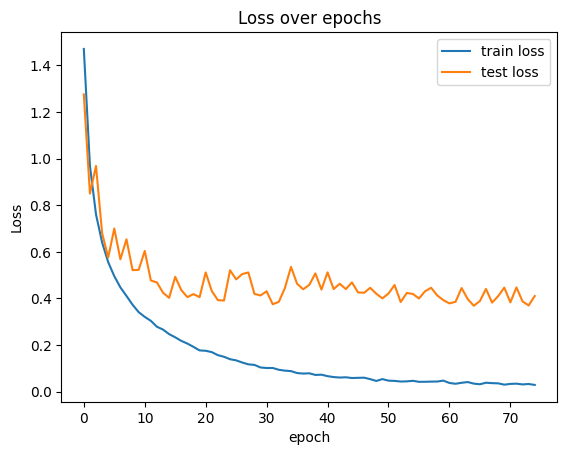

In [ ]:
# SGD:  Trainging Loss VS Testing Loss
plt.plot(epoch, train_loss, label="train loss")
plt.plot(epoch,test_loss, label="test loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.show()

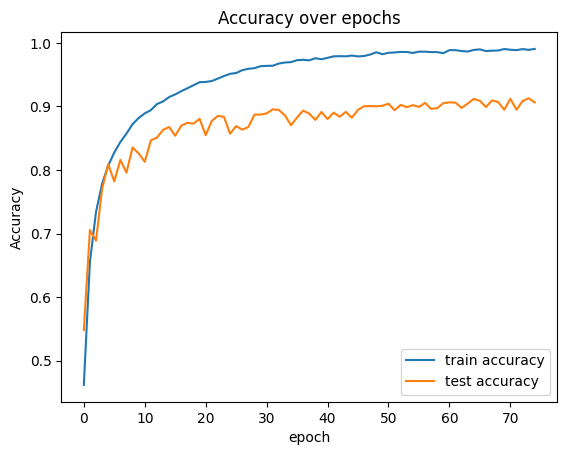

In [ ]:
# SGD:  Trainging Accuracy VS Testing Accuracy
plt.plot(epoch, train_acc, label="train accuracy")
plt.plot(epoch,test_acc, label="test accuracy")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.show()

In [ ]:
# Get predictions from the model
def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            labels.append(y)
            probs.append(y_pred)
            
   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

In [ ]:
labels, probs = get_predictions(model, test_loader, device)
pred_labels = torch.argmax(probs, 1)

In [ ]:
labels=labels.cpu().numpy()
pred_labels=pred_labels.cpu().numpy()

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

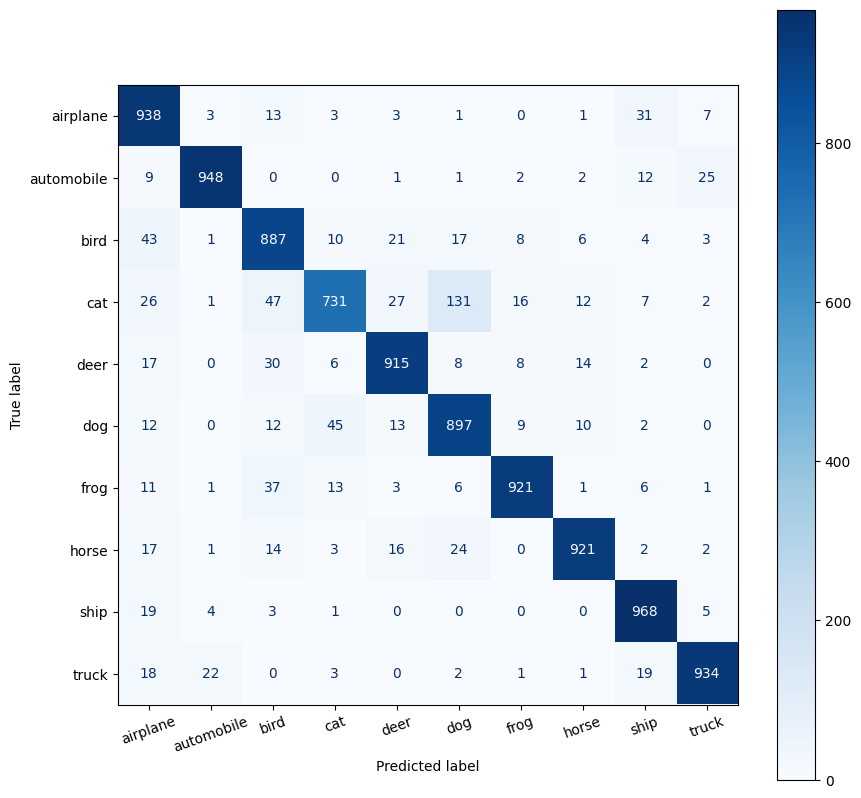

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes) 

MODEL 2(OPTIMIZER = ADAM, LR= 0.005)

In [ ]:
#Instiate and move the model to gpu 
model2 = ResNet18()
model2 = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

In [ ]:
# Using Adam Optimizer for Model 2
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
#Training function
def train_adam(epoch):
    print('\nEpoch: %d' % epoch)
    model2.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device) # Moving images and their labels to the gpu
        optimizer.zero_grad()                                   # setting the gradient to 0                           
        y_pred = model2(inputs)                                 # calculating outputs
        loss = criterion(y_pred, targets)                       # Calculating loss
        acc = calculate_accuracy(y_pred, targets)               # Calculating accuracy                 
        loss.backward()                                         # back propogation step
        optimizer.step()                                        # Update weights using computed gradients
        train_loss += loss.item()
        correct += acc.item()
    return train_loss / len(train_loader), correct / len(train_loader)


In [ ]:
#Testing function
def test_adam(epoch):
    global best_acc
    model2.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device) # Moving images and their labels to the gpu
            outputs = model(inputs)                                 # calculating outputs    
            loss = criterion(outputs, targets)                      # Calculating loss
            acc = calculate_accuracy(outputs, targets)              # Calculating accuracy
            test_loss += loss.item()
            correct += acc.item()
    return test_loss / len(test_loader), correct / len(test_loader)

    # Save checkpoint.
    acc_temp = 100.*correct/total
    if acc_temp > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc_temp,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc_temp


In [ ]:
# Validation Function
def validate_adam(epoch):
    global best_acc
    model2.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device) # Moving images and their labels to the gpu
            outputs = model2(inputs)                                # calculating outputs
            loss = criterion(outputs, targets)                      # Calculating loss
            acc = calculate_accuracy(outputs, targets)              # Calculating accuracy
            test_loss += loss.item()
            # _, predicted = outputs.max(1)
            # total += targets.size(0)
            correct += acc.item()
    return test_loss / len(valid_loader), correct / len(valid_loader)

In [ ]:
#Training, Validation and Testing for Model 2 (Adam)

train_lossa = []
train_acca = []
test_lossa = []
test_acca = []
epocha = []

for e in range(start_epoch, start_epoch+75):
    train_epoch_loss, train_epoch_acc = train_adam(e)
    vaild_epoch_loss, valid_epoch_acc = validate_adam(e)
    test_epoch_loss, test_epoch_acc = test_adam(e)
    train_lossa.append(train_epoch_loss)
    test_lossa.append(test_epoch_loss)
    train_acca.append(train_epoch_acc)
    test_acca.append(test_epoch_acc)
    epocha.append(e)
    print(f'\tTrain Loss: {train_epoch_loss:.3f} | Train Acc: {train_epoch_acc*100:.3f}%')
    print(f'\t Val. Loss: {vaild_epoch_loss:.3f} |  Val. Acc: {valid_epoch_acc*100:.3f}%')


Epoch: 0
	Train Loss: 1.655 | Train Acc: 39.177%
	 Val. Loss: 1.359 |  Val. Acc: 51.055%

Epoch: 1
	Train Loss: 1.113 | Train Acc: 60.005%
	 Val. Loss: 1.076 |  Val. Acc: 61.699%

Epoch: 2
	Train Loss: 0.865 | Train Acc: 69.302%
	 Val. Loss: 0.810 |  Val. Acc: 71.797%

Epoch: 3
	Train Loss: 0.695 | Train Acc: 75.644%
	 Val. Loss: 0.806 |  Val. Acc: 74.082%

Epoch: 4
	Train Loss: 0.584 | Train Acc: 79.611%
	 Val. Loss: 0.699 |  Val. Acc: 76.992%

Epoch: 5
	Train Loss: 0.512 | Train Acc: 82.321%
	 Val. Loss: 0.615 |  Val. Acc: 79.434%

Epoch: 6
	Train Loss: 0.456 | Train Acc: 84.207%
	 Val. Loss: 0.581 |  Val. Acc: 80.996%

Epoch: 7
	Train Loss: 0.405 | Train Acc: 85.989%
	 Val. Loss: 0.516 |  Val. Acc: 82.793%

Epoch: 8
	Train Loss: 0.369 | Train Acc: 87.326%
	 Val. Loss: 0.465 |  Val. Acc: 85.312%

Epoch: 9
	Train Loss: 0.337 | Train Acc: 88.443%
	 Val. Loss: 0.451 |  Val. Acc: 85.801%

Epoch: 10
	Train Loss: 0.307 | Train Acc: 89.316%
	 Val. Loss: 0.424 |  Val. Acc: 86.836%

Epoch: 1

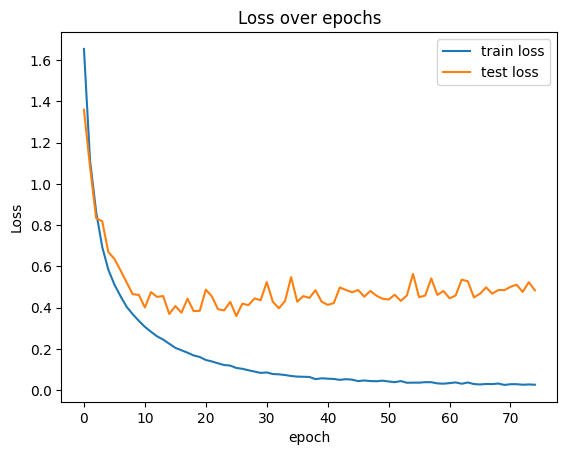

In [ ]:
#Adam Training loss VS Test Loss
plt.plot(epoch, train_lossa, label="train loss")
plt.plot(epoch,test_lossa, label="test loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.show()

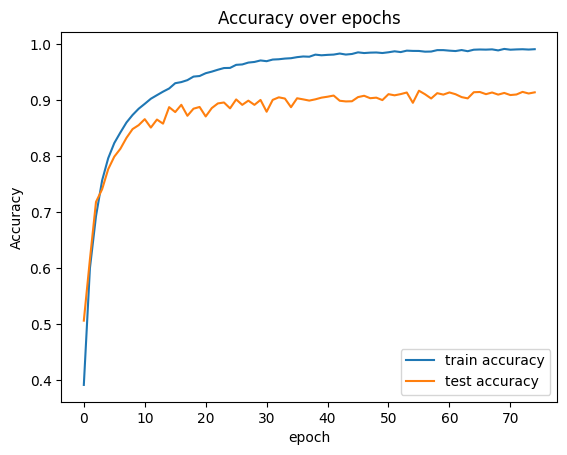

In [ ]:
#Adam: Training Accuracy VS Testing Accuracy
plt.plot(epoch, train_acca, label="train accuracy")
plt.plot(epoch,test_acca, label="test accuracy")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.show()

In [ ]:
labels, probs = get_predictions(model2, test_loader, device)
pred_labels = torch.argmax(probs, 1)

In [ ]:
labels=labels.cpu().numpy()
pred_labels=pred_labels.cpu().numpy()

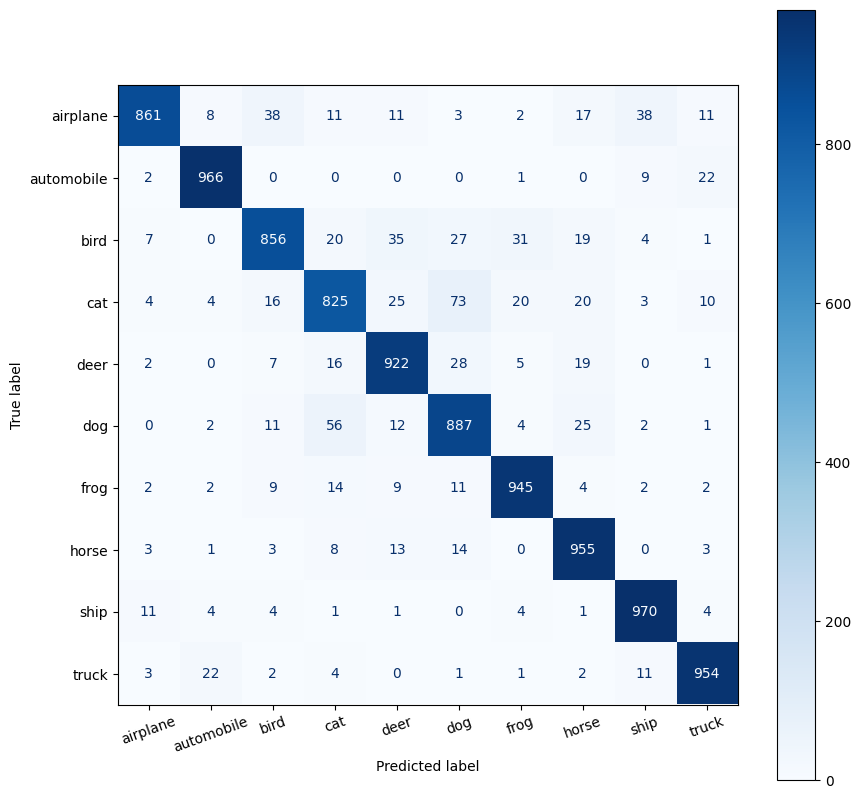

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes) 

# SGD V/S ADAM

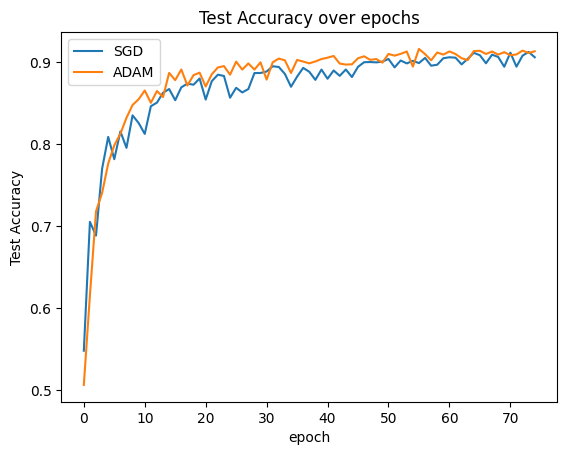

In [ ]:
#Test Accuracy: SGD Vs Adam
plt.plot(epoch, test_acc, label="SGD")
plt.plot(epoch,test_acca, label="ADAM")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy over epochs")
plt.show()

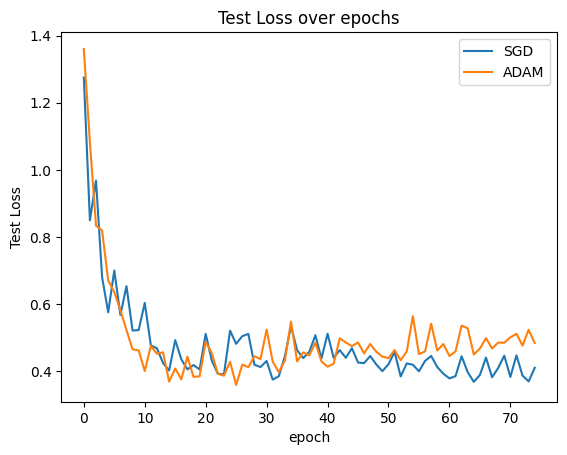

In [ ]:
# Test Loss : SGD VS Adam
plt.plot(epoch, test_loss, label="SGD")
plt.plot(epoch,test_lossa, label="ADAM")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Test Loss")
plt.title("Test Loss over epochs")
plt.show()

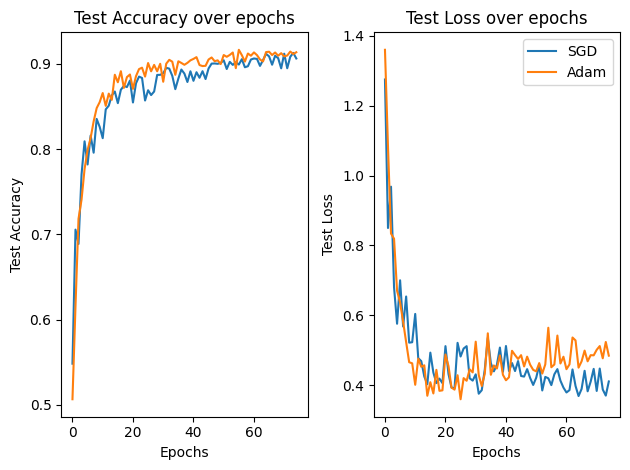

In [ ]:
#Plotting both Test loss curve and Test Accuracy curve for both models
fig, axes = plt.subplots(1, 2)

axes[0].plot(epoch,test_acc, label="SGD")
axes[0].plot(epoch,test_acca,label="Adam")
plt.legend()
axes[0].set_title('Test Accuracy over epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Test Accuracy')

axes[1].plot(epoch,test_loss, label="SGD")
axes[1].plot(epoch,test_lossa, label="Adam")
plt.legend()
axes[1].set_title('Test Loss over epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Test Loss')

plt.tight_layout()

plt.show()
